# Python Assignment 2
### MCT4001 - Kristian Wentzel

## 1. Importing libraries and a .csv-file with the score

I chose the jazz standard "When Sunny Gets Blue" for processing in this assignment.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import IPython.display as ipd
import numpy as np
import pandas as pd

#importing signal processing package from scipy
from scipy import signal


# path/filename for my .csv
file = './Files/my_score.csv'

myscore = pd.read_csv(file)

display(myscore)

frequency  duration  velocity
0      261.63     375.0        46
1      440.00     500.0        80
2      392.00     500.0        65
3      440.00     500.0        65
4      261.63    1125.0        57
5      261.63     375.0        62
6      523.25     375.0        87
7      466.16     375.0        52
8      349.23     375.0        53
9      277.18     375.0        55
10     523.25     375.0        67
11     466.16    1125.0        50
12       0.01     750.0         0
13     440.00     187.5        50
14     392.00     187.5        77
15     349.23     187.5        53
16     329.63     187.5        53
17     293.66     750.0        62
18     392.00     750.0        59
19     329.63    3000.0        59
20     293.66     375.0        57
21     349.23     375.0        65
22     392.00     375.0        34
23     349.23     375.0        57
24     415.30     375.0        30
25     349.23     375.0        59
26     392.00     375.0        32
27     349.23     375.0        51
28     261.63     375.0        36
29     349.23     375.0        57
30     392.00     375.0        32
31     349.23     375.0        59
32     415.30     375.0        30
33     349.23     375.0        71
34     392.00     375.0        51
35     349.23     375.0        53
36     293.66     375.0        47
37     349.23     375.0        59
38     392.00     375.0        59
39     349.23     375.0        65
40     523.25    1125.0        77
41     466.16     187.5        75
42     349.23     187.5        44
43     440.00    3000.0        62
44     440.00     375.0        77
45     523.25     375.0        83
46     587.33     375.0        87
47     523.25     375.0        73
48     622.25     500.0        83
49     523.25     500.0        73
50     415.30     500.0        71
51     392.00    3750.0        59

## 2. Displaying the score

### 2.1 Making a dictionary to store how many times each note is represented

In [2]:
# First, lets make a dictionary of Hz vs Note relations in the range of my score
hz_note = {
    '261.63': 'C4',
    '277.18': 'Db4',
    '293.66': 'D4',
    '311.13': 'Eb4',
    '329.63': 'E4',
    '349.23': 'F4',
    '369.99': 'Gb4',
    '392.0': 'G4',
    '415.3': 'Ab4',
    '440.0': 'A4',
    '466.16': 'Bb4',
    '493.88': 'B4',
    '523.25': 'C5',
    '554.37': 'Db5',
    '587.33': 'D5',
    '622.25': 'Eb5',
}


# Then, I'll make a new dictionary to show how many times each note is represented.
# Initializing with the value 0 for each note, referencing to the hz_note dictionary for notenames.
note_count = {}

for note in hz_note:
    note_count[hz_note[note]] = 0


# Iterating over my_score.csv to add notes as they appear
for row in myscore.itertuples():

    # Skipping the "silence"
    if row[1] < 1:
        continue
    
    # Referencing to hz_note for notenames instead of Hz
    note = hz_note[str(row[1])]
    note_count[note] += 1

# Printing entries of the finalized dictionary
for note, amount in note_count.items():
    print(f'{note}:\t{amount}')

C4:	4
Db4:	1
D4:	3
Eb4:	0
E4:	2
F4:	13
Gb4:	0
G4:	9
Ab4:	3
A4:	5
Bb4:	3
B4:	0
C5:	6
Db5:	0
D5:	1
Eb5:	1


### 2.2 Plotting the score

As the spectogram plotting of the synthesized score further below is going to somewhat resemble a piano roll, I'll try a different approach in plotting the score here. First by visualizing how many times each note is played, then showing the noteheight per note as they appear consecutively.

**Times Played:**

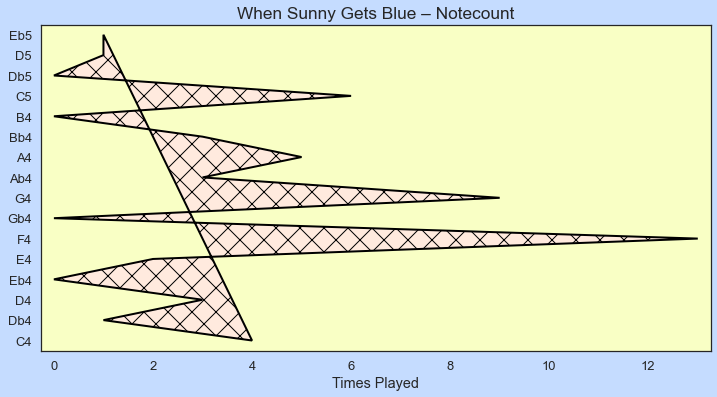

In [3]:
# Changing size and colors of the plot
plt.style.use('seaborn-talk')
plt.style.use('seaborn-white')

# Plotting with different design choices
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#c5dcff')
ax.set_facecolor('#f9ffc5')
ax.set_title('When Sunny Gets Blue – Notecount', fontsize='xx-large')
ax.set_xlabel('Times Played', fontsize='x-large')

# Making slight air between plot and borders
ax.set_xmargin(0.02)
ax.axis(ymin=-0.5, ymax=15.5)

plt.fill(note_count.values(), note_count.keys(), ec='k', fc='#ffeade', lw=2, hatch='x')
plt.show()

**Noteheight per note:**

You can see the shape of the melody as the notes step up and down.

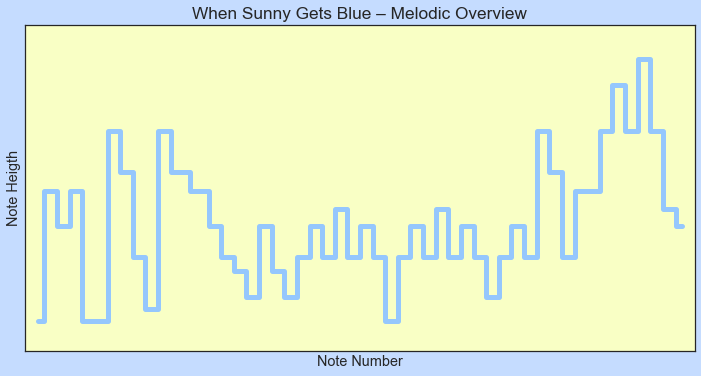

In [4]:
# Filtering out the silence for plotting notes as they appear
restless_score = myscore[myscore.frequency > 1]

# New plot with new design choices
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#c5dcff')
ax.set_facecolor('#f9ffc5')
ax.set_title('When Sunny Gets Blue – Melodic Overview', fontsize='xx-large')
ax.set_xlabel('Note Number', fontsize='x-large')
ax.set_ylabel('Note Heigth', fontsize='x-large')
ax.set_xmargin(0.02)
ax.axis(ymin=220, ymax=670)
ax.set_yticks([])
ax.set_xticks([])

ax.plot(restless_score.index.values, restless_score['frequency'], lw=5, c='#95c7fd', ds='steps-mid')
plt.show()

## 3. Defining functions for synthesis

- Setting the samplerate
- Creating a function to adjust array lengths
- Revisiting the good old sine_synth
- Making a chirp function for note glides
- Velocity to Amplitude
- msToSample() function
- Envelope generator (ADSR)

In [5]:
# Set the samplerate
sr = 48000

# Using a function to adjust the amp envelope to the same size as the generated sine
def sizeAdjust(amp, dur_ms):
    
    # Adjust length if different
    if amp.size != dur_ms.size:
        
        # Deleting if too big
        if amp.size > dur_ms.size:
            diff = amp.size-dur_ms.size            
            amp = np.delete(amp, diff)
            
        # Zero-padding if too small
        elif dur_ms.size > amp.size:
            padding = dur_ms.size - amp.size
            amp = np.pad(amp, padding)
            amp = amp[padding:amp.size]
            
    # Do nothing if they have the same size
    else:
        pass
    
    return amp


# Defining the sine_synth function
def sine_synth(freq, dur_ms, amp=1, pha=0, sr=sr):
    
    t = np.arange(0,(dur_ms/1000),1/sr)
    
    # Adjusting the arrays to the same length
    amp = sizeAdjust(amp, t)
    
    s = amp*np.sin(2*np.pi*freq*t+pha)
   
    return s


# Defining a Chirp function for making glides
def myChirp(hz_from, hz_to, dur_ms):
    t = np.arange(0,(dur_ms/1000),1/sr)
    chirp = signal.chirp(t, f0=hz_from, f1=hz_to, t1=dur_ms/1000, method='logarithmic',
          vertex_zero=False)

    return chirp


# Function for scaling MIDI Velocity to amplitude,
# as I played the melody on my keyboard to get dynamic values for amplitude.
#
# An offset of +1 to not have the waveform go completely silent is by intention;
# to avoid a divided by zero warning when plotting the spectogram.
def vel_to_amp(vel):

    amp = (vel+1)/128
    
    return amp


### 3.1 Envelope generator (ADSR)

I tried different approaches for making an amplitude envelope, and chose this AHD-envelope. The other contestant was an envelope with option to set the fadein/fadeout in ms (default=15 ms) instead of a division relative of the note – a more functional envelope just to smooth the curves. But I liked this approach better for a jazz ballad, as it sounded more organic to me to have longer attack/decay times for longer notes.

Although the envelope was not that hard of a challenge by itself, I really struggled with making what I originally had in mind. I'd love to make an ADSR, but what's holding me back is currently the issue of overlapping segments/notes. Since the release stage would have to engage the moment the (attack stage of the) next tone triggers. This is also what's holding me back from making segments overlap as suggested in the feedback of my previous assignment. (To make crossfades between segments instead of just fading out before fading in the new segment.) I'll dig into this later, but the week unfortunately only had so many hours available.

---

I also made a version of the ADSR where the release had the same relative length as the attack. But this didn't sound good when a short note followed a long note, as the short note would be "swallowed" by the release tail of the previus note.

In [6]:
# Setting a global release time in ms (to the length of a 16th note)
release = int(3000/16)

# Defining a function to convert release time from ms to samples
def msToSample(ms):
    rel = int(ms/1000*sr)
    
    return rel

# Converting release time from ms to number of samples, for use with ADSR/synth arrays
rel_smp = msToSample(release)

In [7]:
# An ADSR-style envelope generator (Attack, Decay, Sustain, Decay) where you can set the hold amplitude.
def envelope(dur_ms, amp=1, sr=sr, rel=rel_smp):
    
    # Using the same timeframe(s) as the sine_synth
    t = np.arange(0, dur_ms/1000, 1/sr)
    
    # Separating the stages of the envelope relative to the note length with a long sustain time (55%),
    # and shorter attack (15%) and decay (30%) times. The release has a constant length set globally.
    attack_length = int(len(t) * 0.15)
    decay_length = int(len(t) * 0.30)
    sustain_length = int(len(t) * 0.55)
    release_length = rel
    
    # Setting sustain volume to 75% of the velocity
    susVol = amp * 0.75
    
    # Making ramps up to the desired amplitude and back down
    attack = np.linspace(0, amp, num=attack_length)
    decay = np.linspace(amp, susVol, num=decay_length)
    sustain = np.linspace(susVol, susVol, num=sustain_length)
    release = np.linspace(susVol, 0, num=release_length)
    
    # Assembling the curve
    env = np.concatenate((attack, decay, sustain, release))
    
    return env

## 4. Synthesizing the score

In [8]:
# Initializing a synth-array
melody = ()

# Setting the crossfade window for glide/note overlap to 20 ms
x_fade = int(sr*0.02)

# Synthesizing a sequence of sines, according to the my_score.csv
for index, row in myscore.iterrows():  

    # Synthesizing the first note
    if len(melody) == 0:
        
        # frequency = row[0], duration = row[1], velocity = row[2]
        freq, dur, vel = row[0], row[1], row[2]

        # Generating amp values from velocity and synthesizing
        amp = vel_to_amp(vel)
        temp_synth = sine_synth(freq, dur+release, envelope(dur, amp))
        
        # Adding the note to the melody
        melody = np.append(melody, temp_synth)
        
        # Storing the last frequency for making glide
        last_freq = freq

    # The rest of the notes get a glide, before being padded and overlapped with the previous notes release
    else:
        
        # frequency = row[0], duration = row[1], velocity = row[2]
        freq, dur, vel = row[0], row[1], row[2]

        # Making a glide up an octav if last note was silence (0Hz)
        if last_freq < 1:
            last_freq = freq * 0.5
        # Making a slight scoop up if the last note was the same as the current
        elif last_freq == freq:
            last_freq = freq * 0.9

        # Generating amp values from velocity
        amp = vel_to_amp(vel)

        # Using the myChirp function to synthesize the glide,
        # and setting the glide to the same length as the attack stage of the envelope
        atk_len = int(dur * 0.15)
        glid_atk = msToSample(atk_len)
        glid_synth = myChirp(last_freq, freq, atk_len)
        
        # Making a similar attack as the envelope generator for the glide
        glid_env = np.linspace(0, amp, num=glid_atk)

        # Adjusting numbers
        glid_env = sizeAdjust(glid_env, glid_synth)
    
        # Applying the attack fade-in to the glide
        glid_synth = glid_synth * glid_env
        # Fading out the glide for overlapping with the note
        glid_synth[-x_fade:] *= np.linspace(1,0,x_fade)
               
        # Synthesizing the note
        amp = vel_to_amp(vel)
        temp_synth = sine_synth(freq, dur+release, envelope(dur, amp))

        # Removing the start and making a fade-in for overlapping with the glide
        temp_synth[:glid_synth.size-x_fade] = np.zeros(glid_synth.size-x_fade)
        temp_synth[glid_synth.size-x_fade:glid_synth.size] *= np.linspace(0,1,x_fade)
    
        # Padding the glide to the length of the note
        glidpad = temp_synth.size - glid_synth.size
        glid_synth = np.pad(glid_synth, glidpad)
        glid_synth = glid_synth[glidpad:glid_synth.size]

        # Summing the glide with the note
        temp_synth += glid_synth
        
        # Padding the melody with the length of the new note minus its release
        padding = temp_synth.size - rel_smp
        melody = np.pad(melody, padding)
        melody = melody[padding:melody.size]

        # Making a overlapping chunk by summing the new note with the last release stage of the melody
        overlap = melody[(melody.size-temp_synth.size):] + temp_synth
        
        # Swapping the release and zero-padding of the melody with the overlap chunk
        melody = np.append(melody[:-temp_synth.size], overlap)
        
        # Storing the last frequency for making new glides
        last_freq = freq

        
# Normalizing and slightly attenuating the melody
melody = (melody/np.max(melody))*0.9

# Audio playback
ipd.Audio(melody, rate=sr)

### 4.1 Plotting the waveform

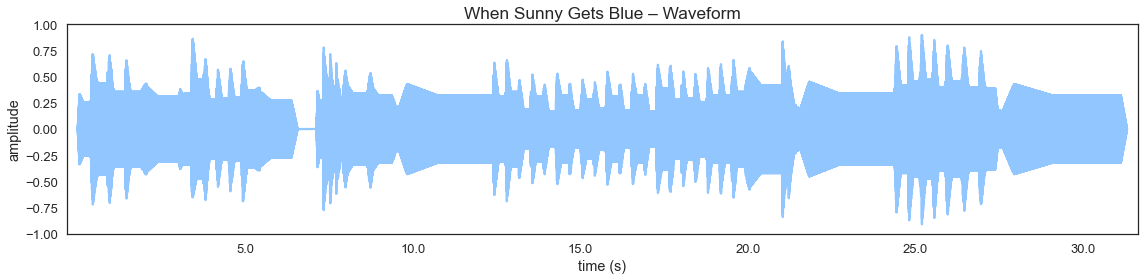

In [9]:
# Tweaking the style and making the plot
plt.style.use('seaborn-pastel')
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(melody)

ax.set_title('When Sunny Gets Blue – Waveform', fontsize='xx-large')
ax.set_xlabel('time (s)', fontsize='x-large')
ax.set_ylabel('amplitude', fontsize='x-large')
ax.set_xmargin(0.01)

# Generating lists for showing x-axis ticks every 5th second,
# by finding the floor value of (length // 5) + 1 for the np.arange().
tick_stop = ((len(melody)/sr)//5)+1
s_ticks_value = np.arange(sr*5,sr*5*tick_stop,sr*5)
s_ticks = np.arange(5,5*tick_stop,5)

# Showing seconds instead of samples
ax.set_xticks(s_ticks_value)
ax.set_xticklabels(s_ticks)

# Ensuring that the y-axis show the full potential amplitude (-1/1)
ax.axis(ymin=-1, ymax=1)

# The plot thickens
fig.tight_layout()
plt.show()

### 4.2 Plotting the spectogram

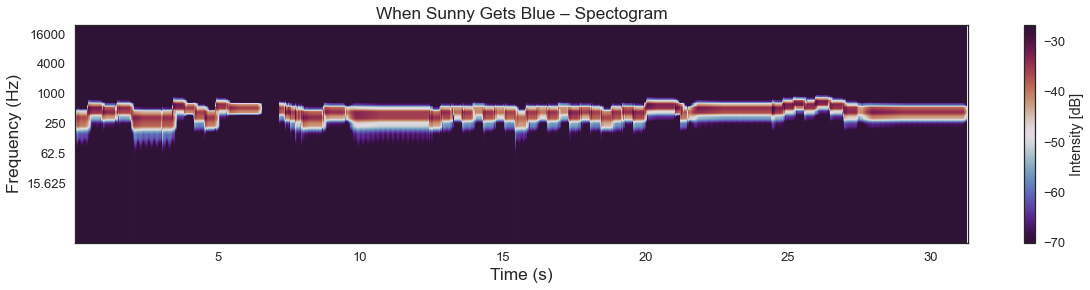

In [10]:
# Making a plot
fig, ax = plt.subplots(figsize=(20, 4))

ax.set_title('When Sunny Gets Blue – Spectogram', fontsize='xx-large')
ax.set_xlabel('Time (s)', fontsize='xx-large')
ax.set_ylabel('Frequency (Hz)', fontsize='xx-large')

# Scaling the dB coloring with vmin/vmax to "filter" out spectral noise making each note too thick
vmin, vmax = -70, -30

# Generating the spectogram
s_spect, s_freqs, s_t, s_axim = ax.specgram(melody, Fs=sr, NFFT=512, vmin=vmin, cmap='twilight_shifted')

# Making the spectogram logarithmic, with manual yticks
ax.set_yscale('log')
ax.set_yticks([15.625,62.5,250,1000,4000,16000], ['15.625','62.5','250','1000','4000','16000'])

# Making sure the plot ranges from 1Hz to the Nyquist frequency
ax.set_ylim(ymin=1, ymax=sr/2)

# Making a colorbar for the dB
fig.colorbar(s_axim).set_label('Intensity [dB]', fontsize='x-large')

plt.show()

## 5. Analysis

I choose to extract the Tonal Centroid Features (Tonnetz) and the Constant-Q Chromagram.

First I'll plot them in an unconventional way to make some appealing(?) visuals, then I'll plot them in a more traditional fashion to see if there is any relationship between the two features.

In [11]:
import librosa

### 5.1 Tonal Centroid Features

Some twisted spaghetti.

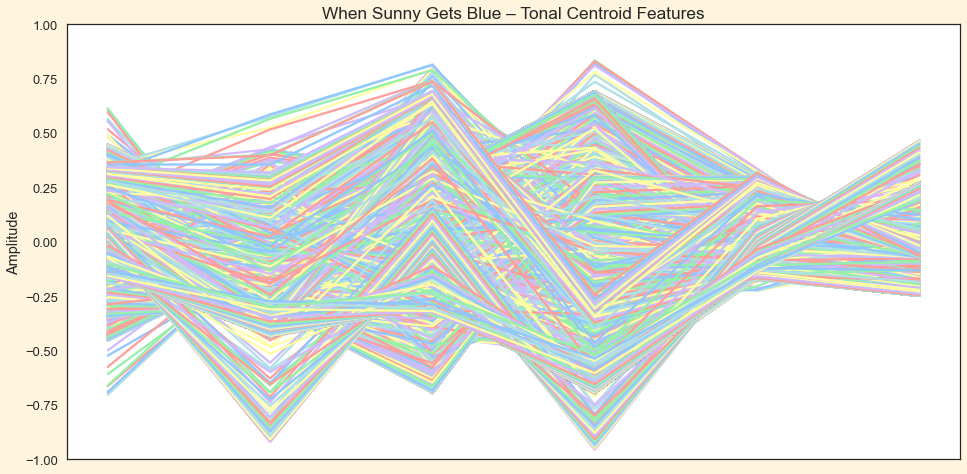

In [12]:
# Extracting Tonnetz
tonnetz = librosa.feature.tonnetz(melody)

# Making a nice layout
fig, ax = plt.subplots(figsize=(16, 8), facecolor='#fff5df')
ax.set_title('When Sunny Gets Blue – Tonal Centroid Features', fontsize='xx-large')
ax.set_ylabel('Amplitude', fontsize='x-large')
ax.set_xticks([])

# Showing the full potential amplitude
ax.axis(ymin=-1, ymax=1)

ax.plot(tonnetz)
plt.show()

### 5.2 Constant-Q Chromagram
Reminds me of nature.

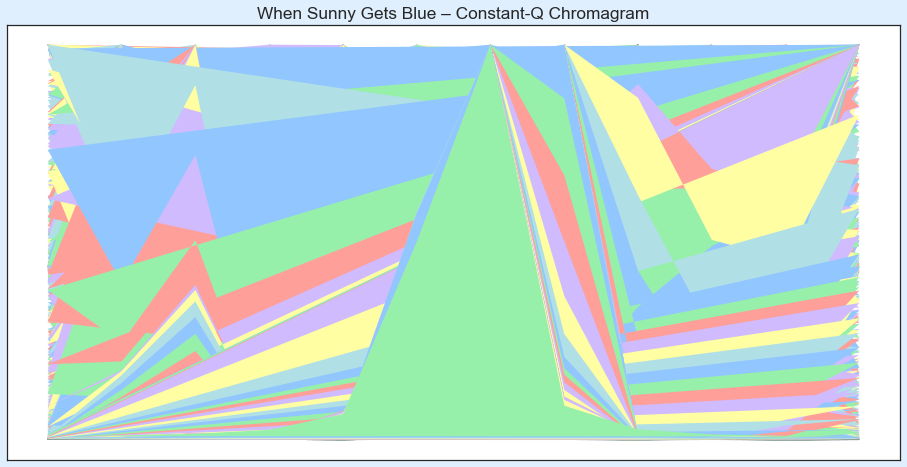

In [13]:
# Extracting Constant-Q chromagram
chroma_cqt = librosa.feature.chroma_cqt(melody)

# Making a nice layout
fig, ax = plt.subplots(figsize=(16, 8), facecolor='#e0effe')
ax.set_title('When Sunny Gets Blue – Constant-Q Chromagram', fontsize='xx-large')
ax.set_xticks([])
ax.set_yticks([])

ax.fill(chroma_cqt)
plt.show()

### 5.3 Tonnetz vs Constant-Q Chromagram

You can clearly see that there is a relationship between the two features looking at the following plots. It would have been interesting to see how the Tonnetz react to harmonies in the source material. The section where there is some noise in both plots is where I placed a rest in the score. (Which in reality is a 0.01Hz note at extremely low amplitude. This might explain the noise.)

The cell magic `%%capture --no-display` below is used to suppress annoying UserWarning from ipython when trying to set my own y-axis ticks.

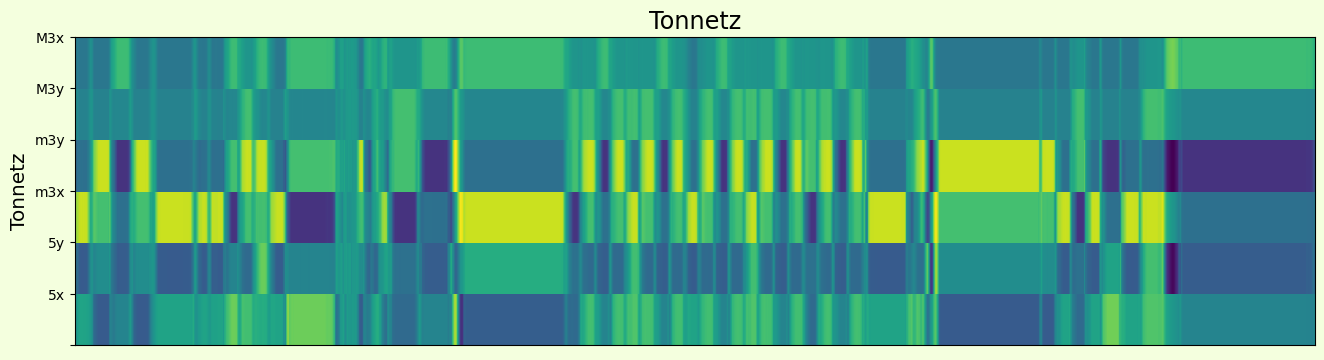

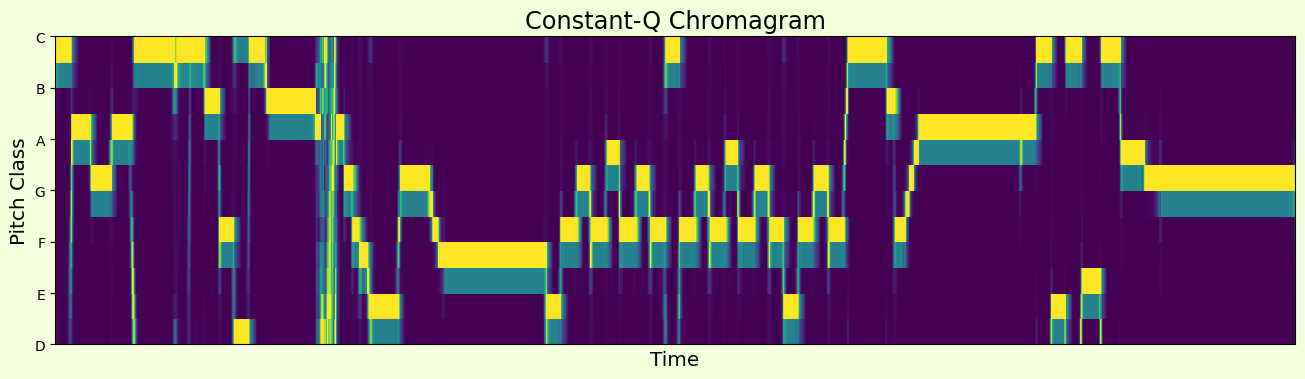

In [14]:
%%capture --no-display

# Changing the appearance
plt.style.use('default')

# Tonnetz
fig, ax = plt.subplots(figsize=(16, 4), facecolor='#f4ffde')
ax.pcolor(tonnetz)
plt.title('Tonnetz', fontsize='xx-large')
plt.ylabel('Tonnetz', fontsize='x-large')
plt.xticks([])
# Placing y-ticks approximately
ax.set_yticklabels(['','5x','5y','m3x','m3y','M3y','M3x'])
plt.show()

# Constant-Q Chromagram
fig2, ax2 = plt.subplots(figsize=(16, 4), facecolor='#f4ffde')
ax2.pcolor(chroma_cqt)
plt.title('Constant-Q Chromagram', fontsize='xx-large')
plt.xlabel('Time', fontsize='x-large')
plt.ylabel('Pitch Class', fontsize='x-large')
plt.xticks([])
# Placing y-ticks approximately
ax2.set_yticklabels(['D','E','F','G','A','B','C'])
plt.show()

## 6. Storing the features as Pandas DataFrames to .csv

In [15]:
# Making and displaying Pandas DataFrames
df_tonnetz = pd.DataFrame(tonnetz)
display(df_tonnetz)

df_chroma_cqt = pd.DataFrame(chroma_cqt)
display(df_chroma_cqt)

0         1         2         3         4         5         6     \
0 -0.197354 -0.138674 -0.076256 -0.032836 -0.006672  0.007240  0.016860   
1 -0.119573 -0.175708 -0.237379 -0.282673 -0.310574 -0.323622 -0.332964   
2  0.432017  0.469665  0.510917  0.541320  0.559388  0.570010  0.580262   
3 -0.459373 -0.418373 -0.376520 -0.349982 -0.333901 -0.323005 -0.314675   
4  0.018071 -0.016951 -0.054422 -0.080857 -0.096789 -0.105564 -0.112486   
5 -0.218042 -0.216968 -0.216926 -0.218288 -0.219286 -0.218972 -0.219090   

       7         8         9     ...      2926      2927      2928      2929  \
0  0.026221  0.036909  0.049525  ... -0.154740 -0.155528 -0.156401 -0.157446   
1 -0.344686 -0.360497 -0.379020  ... -0.400429 -0.395226 -0.388662 -0.379502   
2  0.592373  0.607366  0.624005  ... -0.309984 -0.311467 -0.313736 -0.316394   
3 -0.308431 -0.303929 -0.300299  ... -0.677100 -0.674017 -0.669999 -0.664041   
4 -0.119702 -0.128187 -0.137773  ... -0.134191 -0.134886 -0.135690 -0.136649   
5 -0.220627 -0.223700 -0.227456  ...  0.258747  0.256595  0.253772  0.249914   

       2930      2931      2932      2933      2934      2935  
0 -0.158750 -0.159047 -0.155120 -0.147440 -0.134657 -0.102435  
1 -0.366892 -0.345261 -0.310228 -0.279480 -0.273015 -0.299034  
2 -0.319051 -0.321674 -0.317759 -0.306612 -0.286936 -0.228090  
3 -0.654441 -0.637013 -0.603675 -0.566775 -0.536278 -0.519637  
4 -0.137705 -0.138231 -0.135493 -0.129140 -0.119368 -0.091917  
5  0.243996  0.234241  0.216501  0.198664  0.189649  0.192921  

[6 rows x 2936 columns]

0         1         2         3         4         5         6     \
0   0.055524  0.054480  0.046060  0.037712  0.033013  0.033731  0.035474   
1   0.009951  0.011242  0.011463  0.011046  0.011617  0.011259  0.010260   
2   0.005790  0.006303  0.006378  0.006372  0.006486  0.006182  0.005783   
3   0.003644  0.004147  0.004226  0.004242  0.004263  0.004172  0.003876   
4   0.004023  0.004212  0.004058  0.004000  0.003968  0.003863  0.003566   
5   0.004777  0.004897  0.004339  0.003999  0.003898  0.003800  0.003478   
6   0.006212  0.006024  0.005232  0.004812  0.004584  0.004338  0.004044   
7   0.005527  0.006274  0.006342  0.006284  0.006198  0.006041  0.005662   
8   0.014970  0.014431  0.012653  0.011558  0.010784  0.010158  0.009541   
9   0.021580  0.026137  0.027931  0.028746  0.028865  0.027956  0.025520   
10  1.000000  0.923209  0.763671  0.667115  0.613352  0.585310  0.564934   
11  0.908796  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

        7         8         9     ...      2926      2927      2928      2929  \
0   0.034830  0.030986  0.025303  ...  0.000405  0.000413  0.000477  0.000629   
1   0.009291  0.007856  0.005977  ...  0.000459  0.000435  0.000607  0.000771   
2   0.005169  0.004320  0.003445  ...  0.000411  0.000475  0.000583  0.000753   
3   0.003466  0.002965  0.002372  ...  0.000378  0.000525  0.000511  0.000768   
4   0.003175  0.002712  0.002236  ...  0.000417  0.000607  0.000923  0.001516   
5   0.003119  0.002711  0.002393  ...  0.465012  0.470225  0.476944  0.486124   
6   0.003677  0.003238  0.002839  ...  1.000000  1.000000  1.000000  1.000000   
7   0.005174  0.004551  0.003910  ...  0.007657  0.008445  0.009384  0.010761   
8   0.008710  0.007870  0.006853  ...  0.000342  0.000397  0.000452  0.000596   
9   0.022411  0.019260  0.016749  ...  0.000434  0.000433  0.000496  0.000778   
10  0.544909  0.523250  0.500287  ...  0.000154  0.000174  0.000224  0.000387   
11  1.000000  1.000000  1.000000  ...  0.000333  0.000373  0.000377  0.000439   

        2930      2931      2932      2933      2934      2935  
0   0.000993  0.001766  0.002739  0.003915  0.006271  0.009936  
1   0.001275  0.002148  0.003221  0.005363  0.008273  0.011834  
2   0.001139  0.002451  0.004459  0.007093  0.010939  0.015808  
3   0.001442  0.003743  0.006672  0.011862  0.018477  0.025844  
4   0.003120  0.007165  0.016492  0.030441  0.046962  0.065759  
5   0.499099  0.520225  0.550969  0.576766  0.573087  0.501162  
6   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
7   0.012804  0.017015  0.031402  0.048503  0.059962  0.087006  
8   0.000942  0.001192  0.004916  0.009791  0.018044  0.026899  
9   0.000637  0.001346  0.002550  0.004838  0.009689  0.014208  
10  0.000560  0.001050  0.001834  0.004021  0.006681  0.010677  
11  0.000885  0.001332  0.001689  0.003496  0.006267  0.008819  

[12 rows x 2936 columns]

In [16]:
# Saving DataFrames to .csv
df_tonnetz.to_csv('./Files/tonnetz.csv')
df_chroma_cqt.to_csv('./Files/chroma_cqt.csv')

## 7. Conclusion

**Data Vizualisation**

I think it was great fun – and very rewarding – to dig into different ways to visualize data. A lot of time was spent trying to realize what I had envisioned in my head, while I stumbled upon new functions and unexpected results who contributed in shaping the plots along the way. I really enjoyed how the two representations of the score turned out.
The artsy representation of extracted features from the waveform is not the best way to get insights on the data (at least withouth getting spiritual), but it was mind-blowing to see how an 6-Dimensional array could turn into pasta when experimenting with different ways to visualize.

---

**1 ) The most challenging part**

The visualizations was also by far the most challenging part. To understand what's happening beneath the surface, and try to find and tweak parameters I want, which may or may not exist. I solved it by frequently visiting matplotlib's webpage and reading the documentation as well as looking up Q&A of others having similar questions – and most importantly: a lot of trial and error.

**2 ) What I've learned**

- I feel I understand more of whats presented to me when looking up documentation on libraries and functions online, as I slowly grasp more of the Python way of thinking.
- Of course I also learned a lot about matplotlib and data visualization, as already mentioned.